In [1]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
# df.head()

In [2]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10.Ticker

5      BTC-USD
16        META
7      EQQQ.DE
15       MC.PA
8      ETH-USD
3      BNB-USD
12     IWDE.MI
6     DOGE-USD
22        TSLA
21        RACE
Name: Ticker, dtype: object

In [3]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# # some Ticker should be adjusted for the data source
# port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [4]:
port_list

['BTC-USD',
 'META',
 'EQQQ.DE',
 'MC.PA',
 'ETH-USD',
 'BNB-USD',
 'IWDE.MI',
 'DOGE-USD',
 'TSLA',
 'RACE']

In [5]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [6]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

df_stocks.head()

Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.761063,127.410179,57.299999,383.397278,208.494690,161.780350,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.288254,134.171707,57.160000,383.351624,207.391495,160.071442,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.288254,135.069366,57.160000,383.351624,207.391495,160.071442,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.288254,136.276779,57.160000,383.351624,207.391495,160.071442,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.288254,144.304153,57.060001,379.738464,211.297409,159.226578,30.102667


In [7]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

Y = returns.copy()
Y.head()

Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002808,0.053069,-0.002443,-0.000119,-0.005291,-0.010563,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,0.000000,0.058905,-0.001749,-0.009425,0.018834,-0.005278,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.009540,-0.005268,0.003680,0.002048,0.002164,-0.003799,0.038801


Calculating the portfolio that maximizes Sharpe ratio

In [8]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.225448,3.210652e-09,0.069723,0.475623,0.000227,3.601758e-09,2.777264e-09,0.002326,0.038124,0.188529


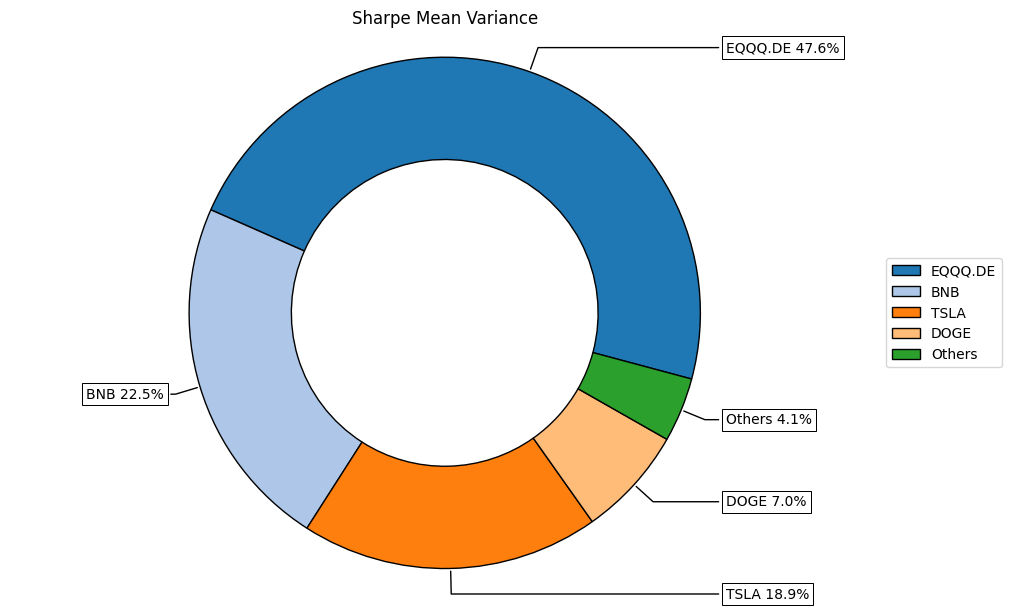

In [ ]:
# Plotting the composition of the portfolio
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

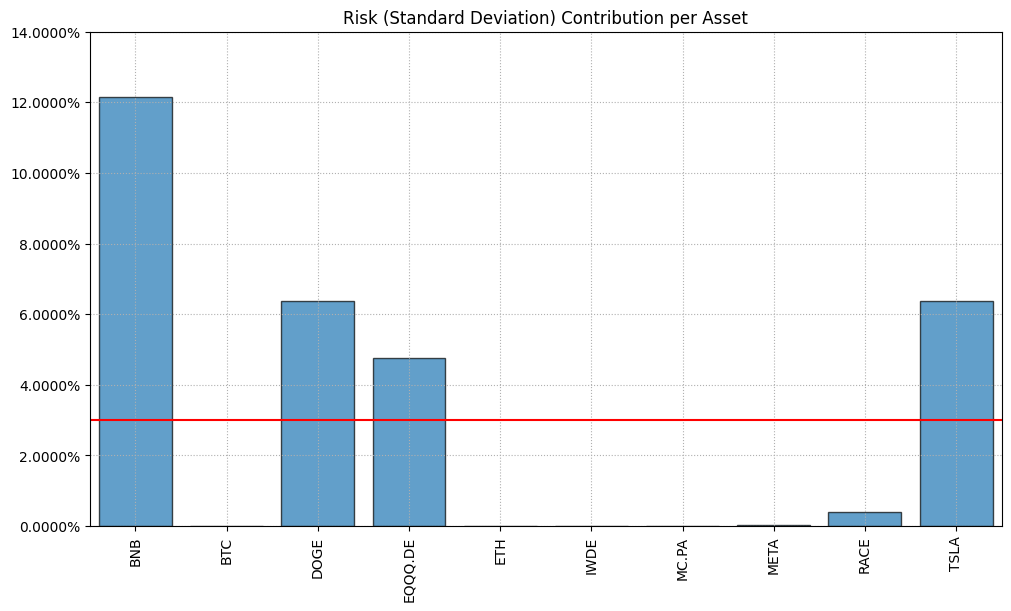

In [10]:
# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

Estimating Risk Parity Portfolios for Other Risk Measures

In [16]:
"""
In this part I will calculate risk parity portfolios. 
First I'm going to calculate risk parity portfolio 
when we use variance as risk measure, 
then I'm going to calculate the risk parity portfolios 
for all available risk measures.
""";

In [12]:
b = None # Risk contribution constraints vector
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
display(w.T)

,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.225448,3.210652e-09,0.069723,0.475623,0.000227,3.601758e-09,2.777264e-09,0.002326,0.038124,0.188529


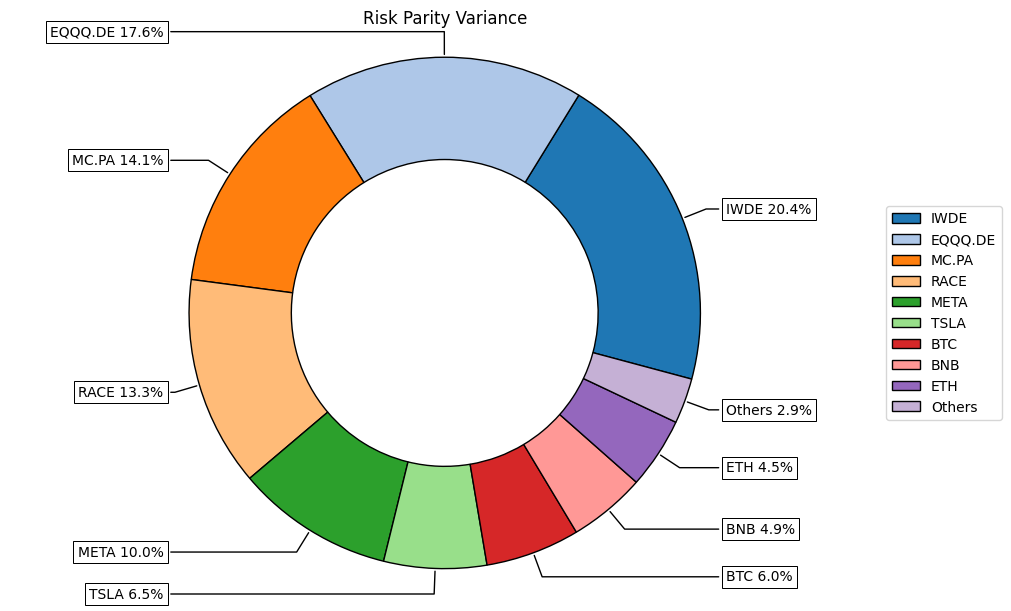

In [13]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

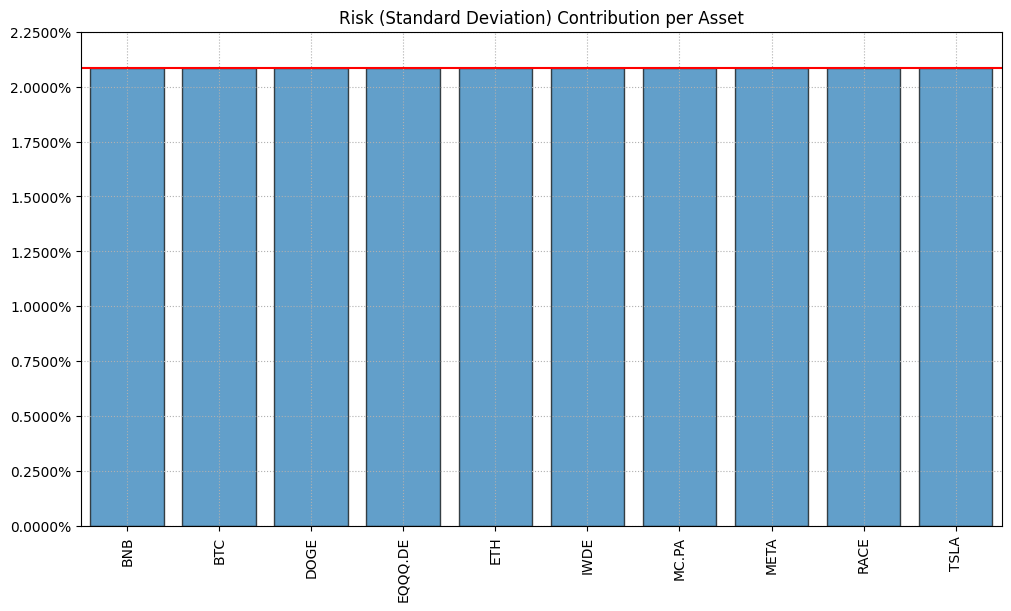

In [14]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

In [15]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']